## Load and select data

sf_use have 20000 samples

In [1]:
import sframe
import pandas as pd
import numpy as np

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 25 days


In [2]:
sf = sframe.load_sframe('./data_sf/text_receiver_sender_small')

2016-03-20 11:21:19,722 [INFO] sframe.cython.cy_server, 172: SFrame v1.8.5 started. Logging /tmp/sframe_server_1458469279.log


In [3]:
sf.show

<bound method SFrame.show of Columns:
	text	str
	receivers	str
	senders	str

Rows: 21701

Data:
+-------------------------------+-------------------------------+
|              text             |           receivers           |
+-------------------------------+-------------------------------+
| 344b81533b796a34c421a3deff... | 4ce8e5745bca246851bc296335... |
| b47b78d46234b18a6416309ac8... | 834153b754a750fa32eb8ff67c... |
| e3d283f2b822e1a83df57d1e1e... | 9934e01ee42946786ec889f928... |
| 5675c3d801bb9fc829d4696324... | 91c7bc2a987c847c8e276afdd7... |
| 44dc5184aac2135a1acbe83496... | e6662ac4f67d84147c1057a9c6... |
| 6d58b8a0e1ccae99a5a483a211... | cb0aec98bef0720963bd09a31a... |
| cc27bf554bd6fff0a5eebc02d9... | edb0221a1339c19d905d6927ad... |
| faae2caa696257b93510afd61a... | 75f371ccd61a5d33ca8b7ae6cb... |
| b10c0968369a934c7f9e672388... | d9271c76465977c78785b9ce38... |
| ef872668a410261e254836afa0... | edb0221a1339c19d905d6927ad... |
+-------------------------------+-------------

In [4]:
#sf_use = sf.sample(.1, seed=5)
#sf = sf_use.save('./data_sf/text_receiver_sender_small')

In [5]:
sf_use = sf.to_dataframe()

In [6]:
sf_use.shape

(21701, 3)

In [7]:
from sklearn.cross_validation import train_test_split

sf_train, sf_test = train_test_split(sf_use,  test_size = 0.2)
print('Sample number of train and test are: %d, %d' % (len(sf_train), len(sf_test))) 

Sample number of train and test are: 17360, 4341


## Seperate test to known label and unknown label

In [10]:
unique_train_senders = np.unique(sf_train['senders'])
unique_train_receivers = np.unique(sf_train['receivers'])

sf_test.loc[:, 'known_s'] = sf_test['senders'].apply(lambda x: 1 if x in unique_train_senders else 0)
sf_test.loc[:, 'known_r'] = sf_test['receivers'].apply(lambda x: 1 if x in unique_train_receivers else 0)

In [9]:
sf_test.head()

,text,receivers,senders,known_s,known_r
12240,2b0ccf61b48253ac3c27b9efb41e7f149286150defcf50...,41b9da605c37d321fcdbed70be36f75b5978a0c44c7ae8...,34c5c6a8ebdf316bf37f5ef03a229d1837ed20e1b40b42...,1,1
9627,a48f2f0350090edab1c8627df26b5b81454942607d9f72...,2d77a135bd4bc7ed35aeb582360f330007aad504a442e6...,61fcf0ee2b2f41501606c0fe1f42332701cb1e31c30a12...,1,1
10164,3e343f0639a9513fb0c2fe77fa19e202612dc0c0770d9c...,7c297a3dbebba540557532cd79b0e717863522ec4ab386...,dc70fd3a9b7ecf54a2bee61d40d8262c30d50f01d7dbb8...,1,1
18575,b75bb61498720b6f3070c7bb5567cac371f04e3e3e4ae2...,fb6ff1de87bad487c7e981c7e8e9eacc0962eba43b447a...,2469aba9d45a63c7537763a05f1461dbcea87b328e0087...,1,1
10808,f38f2be4158dc0e49d4a75983c2fbc2833ba32ab9aa4b3...,834153b754a750fa32eb8ff67c70590b13706165038525...,f6149311800bf4d8031cf36f4eca9f7e43bdbd141f9fea...,1,1


In [11]:
print('Senders:')
print('Number of known senders in train data: %d' % (np.unique(sf_train['senders']).shape[0]))
print('Number of known senders in test data: %d' % (np.unique(sf_test['senders'])).shape[0])
print('Number of samples with known sender in test data: %d' % (sf_test['known_s'].sum()))
print('Percentage of samples with known senders in test data: %.3f'% (float(sf_test['known_s'].sum()) / sf_test.shape[0]))

print ''
print('Receivers:')
print('Number of known receivers in train data: %d' % (np.unique(sf_train['receivers']).shape[0]))
print('Number of known receivers in test data: %d' % (np.unique(sf_test['receivers'])).shape[0])
print('Number of samples with known receivers in test data: %d' % (sf_test['known_r'].sum()))
print('Percentage of samples with known receivers in test data: %.3f'% (float(sf_test['known_r'].sum()) / sf_test.shape[0]))

Senders:
Number of known senders in train data: 2032
Number of known senders in test data: 1008
Number of samples with known sender in test data: 4104
Percentage of samples with known senders in test data: 0.945

Receivers:
Number of known receivers in train data: 560
Number of known receivers in test data: 401
Number of samples with known receivers in test data: 4325
Percentage of samples with known receivers in test data: 0.996


In [12]:
(sf_test['known_s']==1).mean()

0.94540428472702143

## Only looking at the samples with known labels:

In [13]:
sf_test_known_s = sf_test[sf_test['known_s']==1]
sf_test_known_r = sf_test[sf_test['known_r']==1]

In [14]:
#import cPickle as pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score, precision_score
import time

import pylab as plt
%matplotlib inline


sv = LabelEncoder()
rv = LabelEncoder()
dv = TfidfVectorizer(max_df=0.06, min_df=0.001)

## label all known sender and receiver in sf_use

In [15]:
sv.fit(sf_use['senders']) # label all known sender in sf_use
rv.fit(sf_use['receivers']) # label all known receivers in sf_use

LabelEncoder()

In [16]:
sv.classes_.shape

(2258,)

In [17]:
rv.classes_.shape

(576,)

In [18]:
train_X = dv.fit_transform(sf_train['text'])
train_s = sv.transform(sf_train['senders']) 
train_r = rv.transform(sf_train['receivers']) 

In [19]:
val_X_s = dv.transform(sf_test_known_s['text'])
val_s = sv.transform(sf_test_known_s['senders'])

val_X_r = dv.transform(sf_test_known_r['text'])
val_r = rv.transform(sf_test_known_r['receivers'])

In [20]:
train_X.shape

(17360, 19789)

In [21]:
val_X_s.shape

(4104, 19789)

In [22]:
val_X_r.shape

(4325, 19789)

### double check if all the labels in val exist in train labels (should all included)

In [23]:
l3 = np.array([x for x in val_s if x not in train_s])

In [24]:
1 - float(l3.shape[0]) / val_s.shape[0]

1.0

In [25]:
train_s.shape

(17360,)

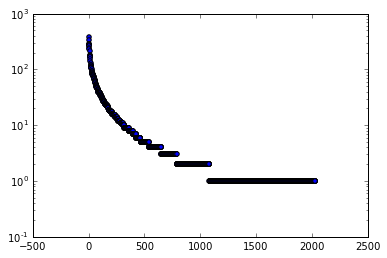

In [26]:
u, c = np.unique(train_s, return_counts=True)
indices = np.argsort(c)[::-1]
fig = plt.scatter(range(u.shape[0]), c[indices])
plt.yscale('log')


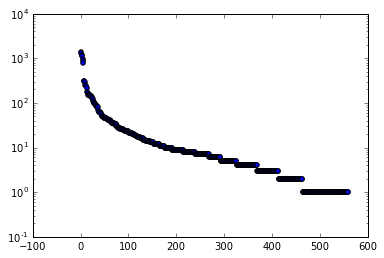

In [27]:
u, c = np.unique(train_r, return_counts=True)
indices = np.argsort(c)[::-1]
fig = plt.scatter(range(u.shape[0]), c[indices])
plt.yscale('log')

In [28]:
train_X.shape

(17360, 19789)

In [29]:
count_train_X = (train_X.toarray()).sum(axis = 0) # note that train_X is a sparse matrix, we change it to an array before plot
type(train_X)

scipy.sparse.csr.csr_matrix

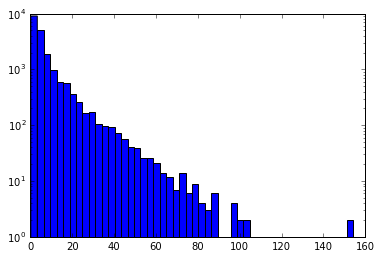

In [30]:
fig = plt.hist(count_train_X, 50)
plt.yscale('log')

In [31]:
count_train_X[0:10]

array([  2.65268931,   3.16944107,  20.45489712,   2.45417142,
         2.65133335,  13.08967759,   1.5865465 ,  29.91861789,
         1.25007178,   4.89332086])

In [32]:
count_train_X.max()

154.15068366849178

In [33]:
count_train_X.max()/13575

0.011355483143166981

In [34]:
clf_s = MultinomialNB(alpha=0.0001, fit_prior=False)
clf_s.fit(train_X, train_s)
pred_s = clf_s.predict(val_X_s)
print f1_score(val_s, pred_s, average='micro')
print f1_score(val_s, pred_s, average='macro')
print f1_score(val_s, pred_s, average='weighted')
print precision_score(val_s, pred_s, average='weighted')

0.971247563353
0.900670585199
0.973704283126
0.980137594443


/Users/fuyangliu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fuyangliu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fuyangliu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
pred_s

array([ 469,  866, 1941, ..., 1087, 1075, 1483])

In [36]:
val_s

array([ 469,  866, 1941, ..., 1087, 1075, 1483])

In [37]:
sv.inverse_transform(1360)

'99d04ab26da340f743eca519c418a7df1ef28234c88c01aacdade64cdef05591\n'

In [38]:
clf_r = MultinomialNB(alpha=0.0001, fit_prior=False)
clf_r.fit(train_X, train_r)
pred_r = clf_r.predict(val_X_r)
print f1_score(val_r, pred_r, average='micro')
print f1_score(val_r, pred_r, average='macro')
print f1_score(val_r, pred_r, average='weighted')
print precision_score(val_r, pred_r, average='weighted')

0.782427745665
0.370613760792
0.805145634982
0.85529063531


# Test some other classifiers

In [39]:
# Not working
#from sklearn.linear_model import LogisticRegression
#clf_s = LogisticRegression(n_jobs=-1)
#clf_s.fit(train_X, train_s)
#pred_s = clf_s.predict(val_X_s)
#print f1_score(val_s, pred_s, average='micro')
#print f1_score(val_s, pred_s, average='macro')
#print f1_score(val_s, pred_s, average='weighted')
#print precision_score(val_s, pred_s, average='weighted')

## Check probability output

### For sender:

In [40]:
pred_prob_s = clf_s.predict_proba(val_X_s)

In [41]:
pred_prob_s.shape

(4104, 2032)

In [42]:
pred_prob_s[0]

array([  3.27969138e-22,   7.23888670e-29,   2.21836288e-24, ...,
         1.76887976e-23,   1.23169267e-23,   8.71179729e-24])

In [43]:
pred_prob_s[0].max()

1.0

In [44]:
clf_s.classes_

array([   0,    1,    2, ..., 2255, 2256, 2257])

#### Now, take a look for the unknown label test:

In [45]:
sf_test_unknown_s = sf_test[sf_test['known_s']==0]

In [46]:
val_X_unk_s = dv.transform(sf_test_unknown_s['text'])
val_unk_s = sv.transform(sf_test_unknown_s['senders'])

In [47]:
pred_unk_s = clf_s.predict(val_X_unk_s)
print f1_score(val_unk_s, pred_unk_s, average='micro')
print f1_score(val_unk_s, pred_unk_s, average='macro')
print f1_score(val_unk_s, pred_unk_s, average='weighted')
print precision_score(val_unk_s, pred_unk_s, average='weighted')

0.0
0.0
0.0
0.0


0.945906432749
0.826037925229
0.930687653983
0.924209846434


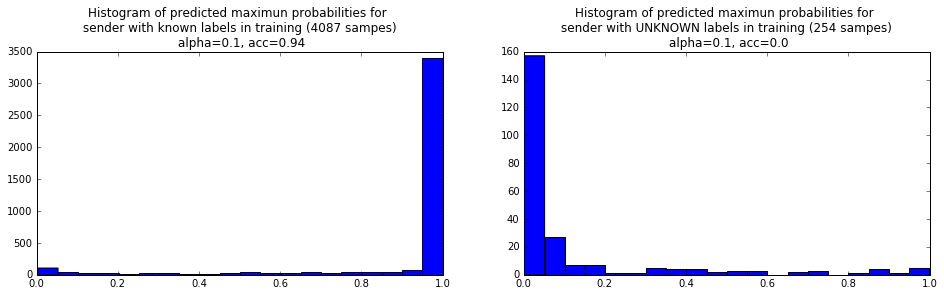

In [48]:
clf_s = MultinomialNB(alpha=0.1, fit_prior=False)
clf_s.fit(train_X, train_s)
pred_s = clf_s.predict(val_X_s)
print f1_score(val_s, pred_s, average='micro')
print f1_score(val_s, pred_s, average='macro')
print f1_score(val_s, pred_s, average='weighted')
print precision_score(val_s, pred_s, average='weighted')

pred_prob_s = clf_s.predict_proba(val_X_s)
pred_prob_unk_s = clf_s.predict_proba(val_X_unk_s)


plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
plt.hist(pred_prob_s.max(axis=1),20)
plt.title('Histogram of predicted maximun probabilities for \n sender with known labels in training (4087 sampes) \n alpha=0.1, acc=0.94')
#plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(pred_prob_unk_s.max(axis=1),20)
plt.title('Histogram of predicted maximun probabilities for \n sender with UNKNOWN labels in training (254 sampes) \n alpha=0.1, acc=0.0')
#plt.yscale('log')